In [7]:
%reload_ext autoreload
%autoreload
%matplotlib inline
import torch
from pathlib import Path

In [8]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
import os

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [10]:
path_hr = Path('chest_xray/images')
path_lr = Path('chest_xray/crappy')
path_reverse = Path('chest_xray/pred_reverse')
path_pred = Path('chest_xray/pred')
path_flpred = Path('chest_xray/predfl1024')
bs = 64

In [11]:
asda = open_image(path_hr/'IM-0684-0001.jpeg')
print(asda.data.shape)
asda.show()

NameError: name 'open_image' is not defined

In [10]:
from fastai.vision import *
import random, string
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        font = ImageFont.truetype('arial.ttf', 80)
        img = img.resize(img.size, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        names = []
        genders = ['M', 'F']
        with open(Path('names.txt')) as f:
            names= list(f)
        name = str(random.choice(names)) + " " + str(random.choice(names))
        ssn = random.randint(10000000000, 99999999999)
        age = "Age: " + str(random.randint(1, 150))
        sex = "Sex: " + random.choice(genders)
        data1 = str(random.randint(1, 9)) + "/" + str(9)
        data2 = "IM #:"
        data3 = "SE #:"
        data4 = "WL: W:" + str(random.randint(0,360)) + "L: " + str(random.randint(0, 360))
        q = ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(1, 8)))
        ImageDraw.Draw(img).text((0, 0), str(name), fill=(255,255,255), font=font) #first text
        ImageDraw.Draw(img).text((0, 150), str(age), fill=(255,255,255), font=font) #second text
        ImageDraw.Draw(img).text((0,300), str(sex), fill=(255,255,255), font=font) #third text
        ImageDraw.Draw(img).text((0,450), str(ssn), fill=(255,255,255), font=font) # fourth text
        ImageDraw.Draw(img).text((w//2, 0), str(name), fill=(255,255,255), font=font) #name right text
        recompute_scale_factor=True


        
        #ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//4)), str(q), fill=(255,255,255), font=font)
        #ImageDraw.Draw(img).text((0, h), str(data4), font=font) #bottom first text
        #ImageDraw.Draw(img).text((0, h-150), str(data3), font=font) #bottom second text
        #ImageDraw.Draw(img).text((0, h-300), str(data2), fill=(255,255,255), font=font) #bottom third text
        #ImageDraw.Draw(img).text((0, h-450), str(data1), fill=(255,255,255), font=font) #bottom fourth text

        img.save(dest)

In [135]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_flpred/names[i].name)
            i += 1

In [136]:
save_preds(data.fix_dl)

FileNotFoundError: [Errno 2] No such file or directory: 'chest_xray/predfl1024/NORMAL2-IM-0653-0001.jpeg'

In [12]:
from PIL import Image, ImageDraw, ImageFont
from random import randint

In [13]:
il = ImageList.from_folder(path_hr)

In [14]:
parallel(crappifier(path_lr, path_hr), il.items)

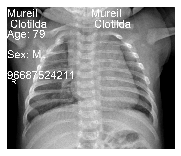

In [15]:
asdasa = open_image(path_lr/'IM-0675-0001.jpeg')
asdasa.show()

In [17]:
#bs,size=32, 128
#bs,size = 24,160
#bs,size = 8, 256
arch = models.resnet34

In [18]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [26]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [27]:
bs,size = 16,256
data = get_data(bs, size)

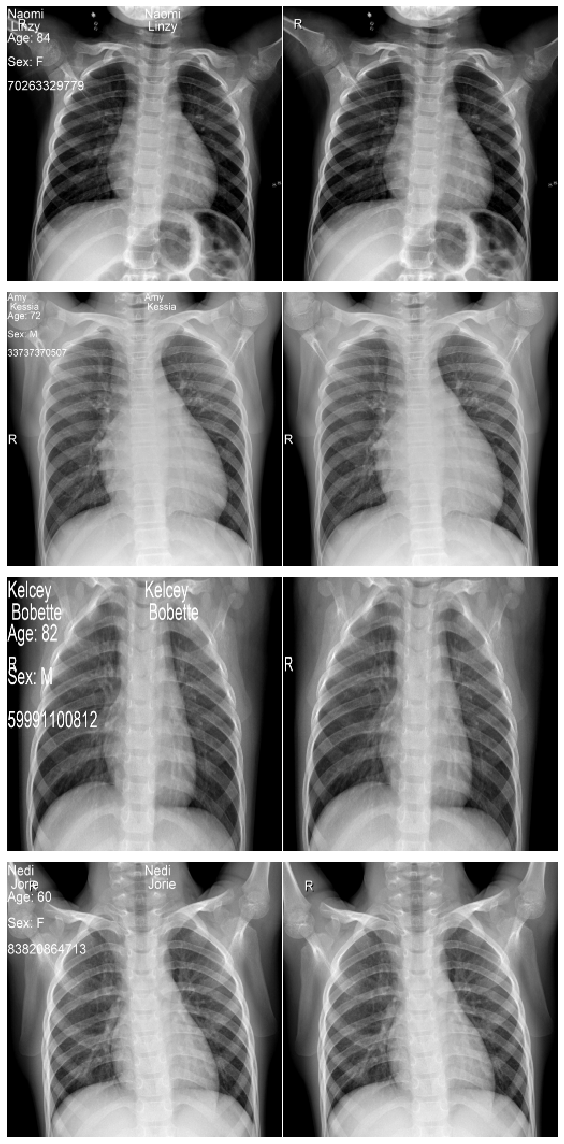

In [28]:
data.show_batch(4)

In [29]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [30]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [31]:
gram_matrix(t)

tensor([[[0.0933, 0.0933, 0.0933],
         [0.0933, 0.0933, 0.0933],
         [0.0933, 0.0933, 0.0933]],

        [[0.0933, 0.0933, 0.0933],
         [0.0933, 0.0933, 0.0933],
         [0.0933, 0.0933, 0.0933]]])

In [32]:
base_loss = F.l1_loss

In [34]:
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/MSc/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [35]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [36]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [37]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [38]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 8.32E-03


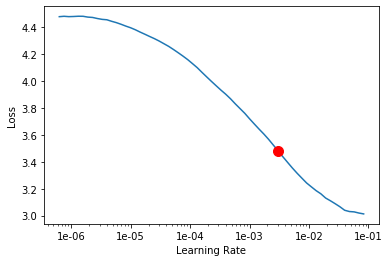

In [41]:
learn.recorder.plot(suggestion=True)

In [43]:
min_grad_lr = learn.recorder.min_grad_lr

learn.fit_one_cycle(10, min_grad_lr, pct_start=0.9)

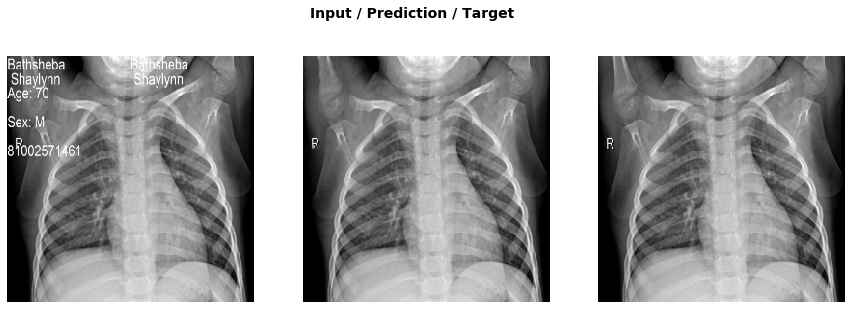

In [44]:
learn.show_results(rows=1, imgsize=5)

In [47]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(10, slice(1e-5,1e-3))

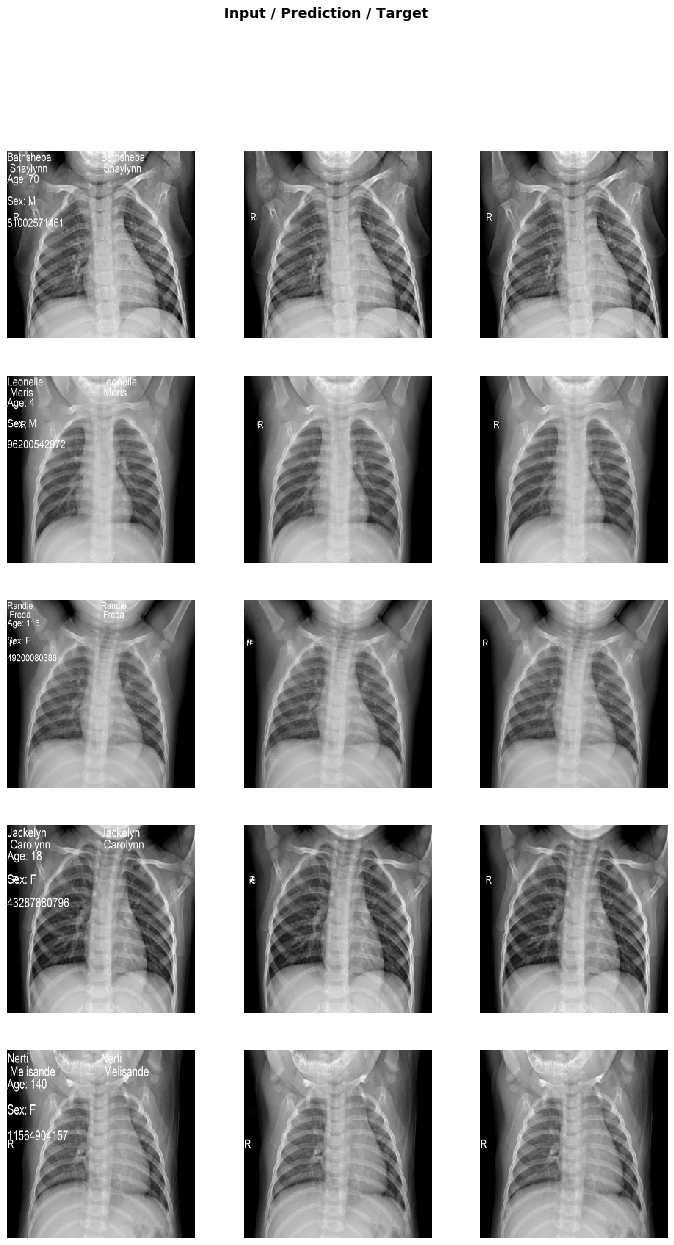

In [50]:
learn.show_results(rows=5)

In [51]:
learn.validate()

[0.24484318]

In [54]:
save_preds(data.fix_dl)

In [57]:
learn.save('256')

In [58]:
torch.cuda.empty_cache()

In [59]:
gc.collect()

2688

In [60]:
data = get_data(8, 512)

In [62]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight).load('256')

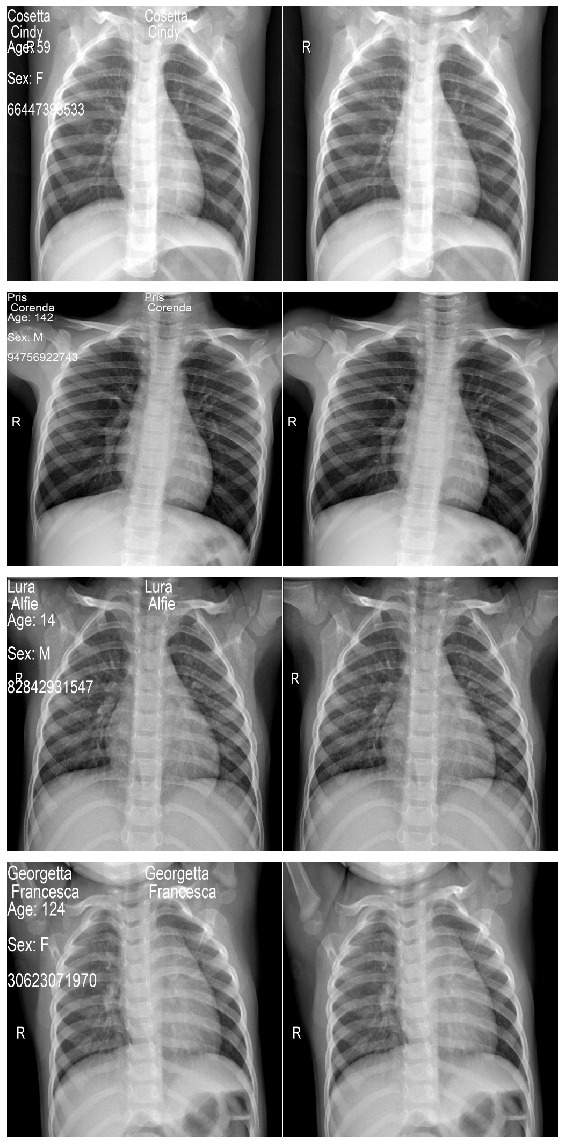

In [63]:
data.show_batch(4)

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.00E-06


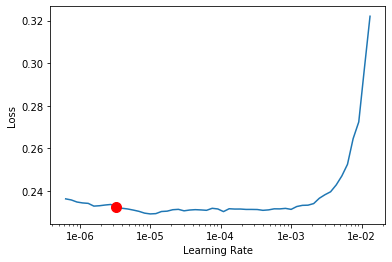

In [65]:
learn.recorder.plot(suggestion=True)

In [37]:
learn.unfreeze()

In [67]:
learn.fit_one_cycle(10, learn.recorder.min_grad_lr)

In [68]:
learn.save('512')

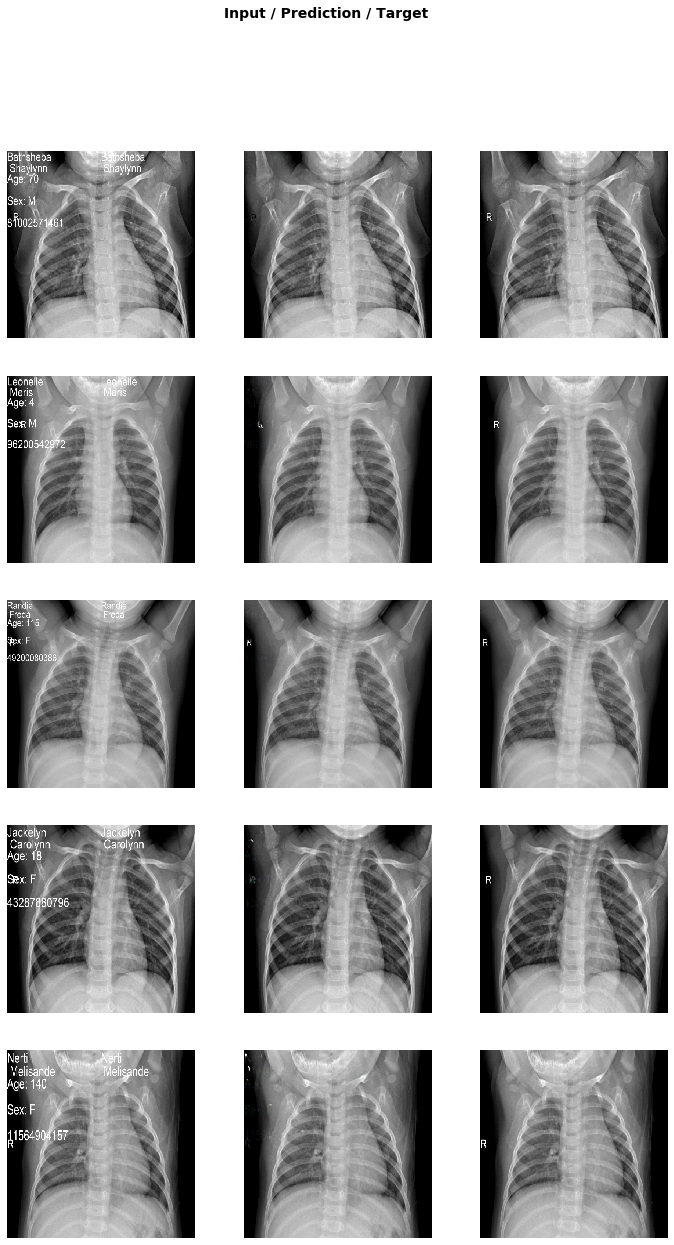

In [69]:
learn.show_results(rows=5)

In [86]:
gc.collect()
learn = None

In [87]:
data=get_data(2,1024)

In [88]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight).load('512')

In [89]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.00E-04


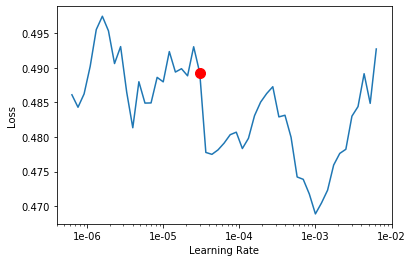

In [90]:
learn.recorder.plot(suggestion=True)

In [91]:
learn.unfreeze()

In [93]:
learn.fit_one_cycle(10, learn.recorder.min_grad_lr)

In [94]:
learn.save('1024')

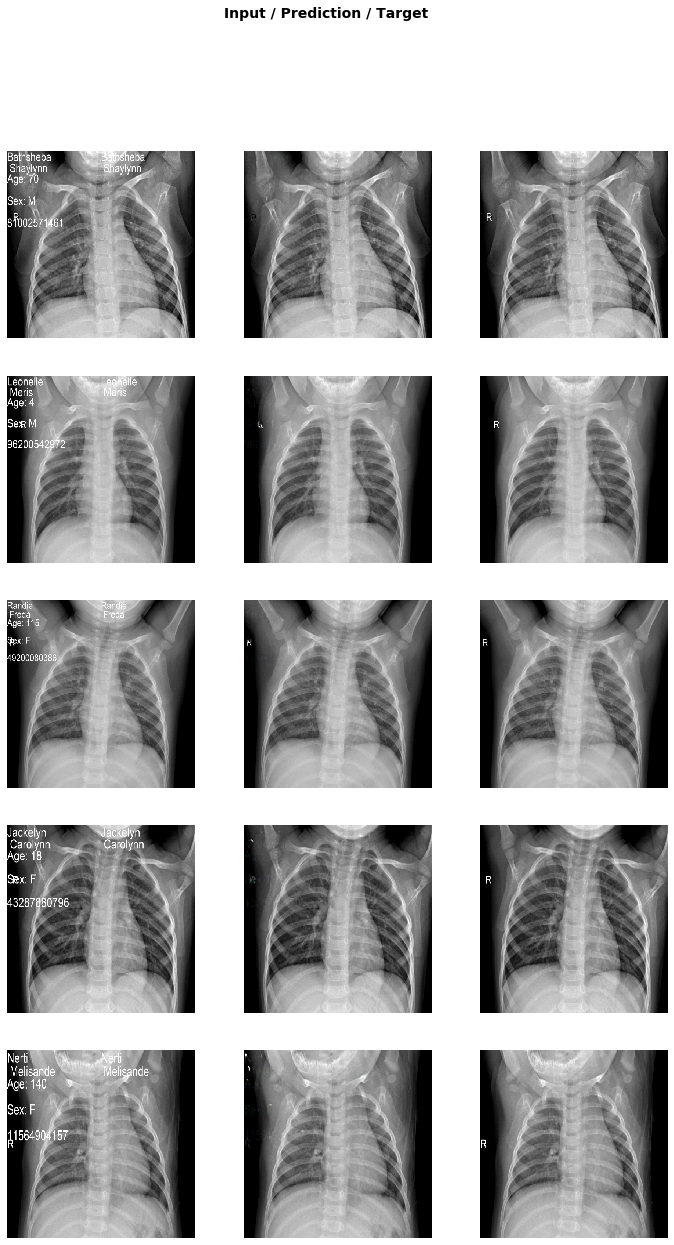

In [95]:
learner.show_results(rows=5)

In [118]:
gc.collect()
learn = None

In [119]:
data=get_data(2,1024)
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [120]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


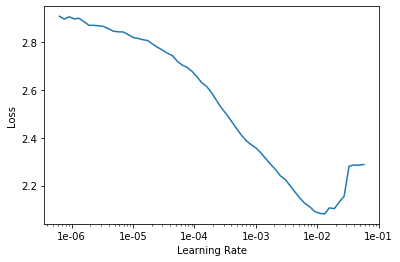

In [121]:
learn.recorder.plot()

In [122]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

In [124]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.58E-05


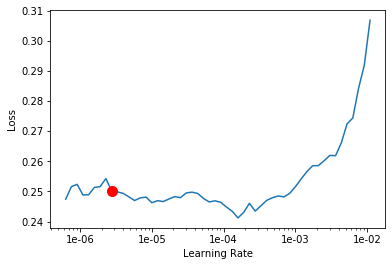

In [126]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [127]:
learn.fit_one_cycle(10, 1e-4)

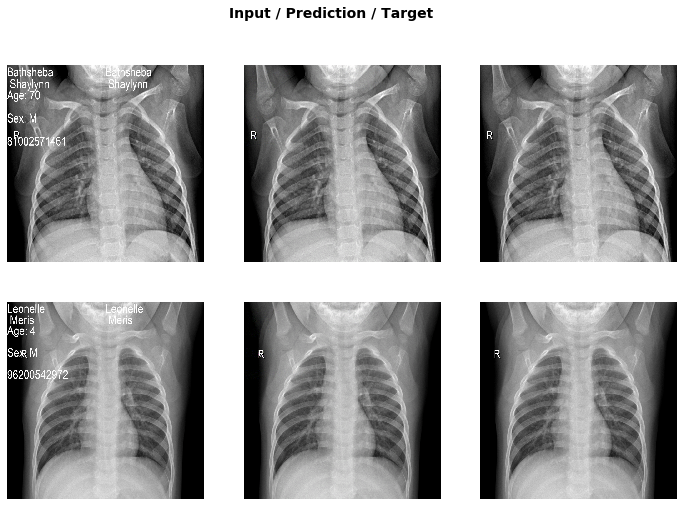

In [129]:
learn.show_results(rows=5)

In [137]:
learn.validate()

[0.2385916]

In [144]:
learn.save('fl1024')

In [69]:
learner.load('1024')

Learner(data=ImageDataBunch;

Train: LabelList (1425 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: data/chest_xray/crappy;

Valid: LabelList (158 items)
x: ImageImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: data/chest_xray/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [71]:
gc.collect()

0

In [72]:
src = ImageImageList.from_folder(path_pred).split_by_rand_pct(0.1, seed=42)

In [73]:
def get_data2(bs,size):
    data = (src.label_from_func(lambda x: path_lr/x.name)
           .transform( size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

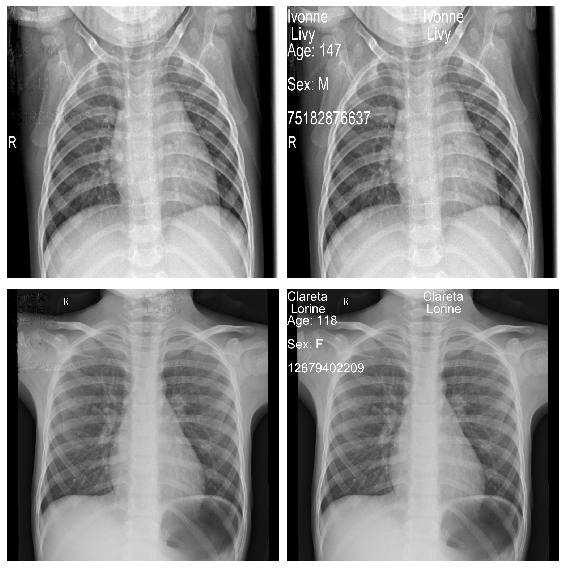

In [74]:
data = get_data2(2,1024)
data.show_batch(4)

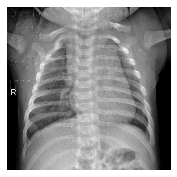

In [75]:
pic_preview = open_image(path_pred/'IM-0675-0001.jpeg')
pic_preview.show()

In [76]:
#learner = create_gen_learner().load('1024')
learner = create_gen_learner()

In [77]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-04
Min loss divided by 10: 2.29E-03


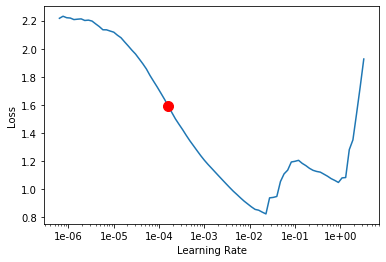

In [78]:
learner.recorder.plot(suggestion=True)

In [79]:
learner.unfreeze()

In [80]:
learner.fit_one_cycle(3, slice(1e-5,1e-2))

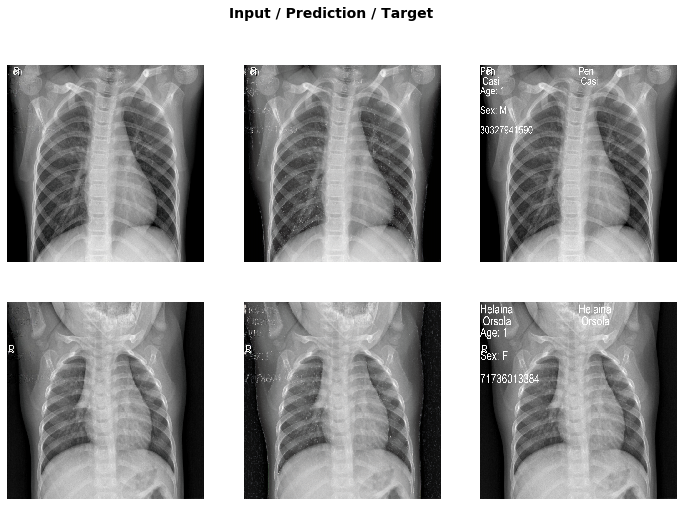

In [81]:
learner.show_results(rows=5)

In [82]:
learner.save('test_prediction')

In [151]:
def save_preds_reverse(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_flpred/names[i].name)
            i += 1

In [152]:
save_preds_reverse(data.fix_dl)